In [1]:
import torch
from torch import no_grad
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss
)
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [3]:
torch.manual_seed(42)
batch_size = 32

# Train DataLoader
data_root = "./birdsong/"

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
train_dataset = custom_dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))

# Test DataLoader
data_root = "./birdsong_test/" 

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
test_dataset = custom_dataset
test_loader = DataLoader(test_dataset, shuffle=False)

print("Number of test samples:", len(test_dataset))

Number of training samples: 1866
Number of test samples: 464


In [4]:
def create_qnn():
    feature_map = ZZFeatureMap(8)
    ansatz = RealAmplitudes(8, reps=1)
    qc = QuantumCircuit(8)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    qc.draw(output="mpl", style="clifford")

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn = create_qnn()

In [5]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.conv3 = Conv2d(16, 64, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(356224, 64)
        self.fc2 = Linear(64, 8)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))     
        x = self.qnn(x)  # apply QNN 
        x= self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [6]:
model = CNN() # Model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer 
loss_func = CrossEntropyLoss() # Loss Functions
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
accuracy_list = []

model.train()  # Set model to training mode

start_time = time.time()

for epoch in range(epochs):
    y_true = []
    y_pred_probs = []
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(loss)
        probabilities = F.softmax(output, dim=1)
        y_true.extend(target.tolist())
        y_pred_probs.extend(probabilities.tolist())
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    y_pred_probs = torch.tensor(y_pred_probs)
    y_pred = torch.argmax(y_pred_probs, dim=1)
    accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
    accuracy_list.append(accuracy.item())
    print("Accuracy:", accuracy.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    
end_time = time.time()  # Record end time
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

tensor(0.9620, grad_fn=<NllLossBackward0>)
tensor(1.2737, grad_fn=<NllLossBackward0>)
tensor(0.8216, grad_fn=<NllLossBackward0>)
tensor(0.9475, grad_fn=<NllLossBackward0>)
tensor(1.1393, grad_fn=<NllLossBackward0>)
tensor(1.3888, grad_fn=<NllLossBackward0>)
tensor(0.8789, grad_fn=<NllLossBackward0>)
tensor(0.9369, grad_fn=<NllLossBackward0>)
tensor(0.9349, grad_fn=<NllLossBackward0>)
tensor(1.0554, grad_fn=<NllLossBackward0>)
tensor(1.1087, grad_fn=<NllLossBackward0>)
tensor(1.0434, grad_fn=<NllLossBackward0>)
tensor(0.9811, grad_fn=<NllLossBackward0>)
tensor(1.0974, grad_fn=<NllLossBackward0>)
tensor(0.9134, grad_fn=<NllLossBackward0>)
tensor(0.9673, grad_fn=<NllLossBackward0>)
tensor(0.8443, grad_fn=<NllLossBackward0>)
tensor(0.7813, grad_fn=<NllLossBackward0>)
tensor(0.9528, grad_fn=<NllLossBackward0>)
tensor(1.2344, grad_fn=<NllLossBackward0>)
tensor(1.1751, grad_fn=<NllLossBackward0>)
tensor(0.8841, grad_fn=<NllLossBackward0>)
tensor(0.9378, grad_fn=<NllLossBackward0>)
tensor(0.82

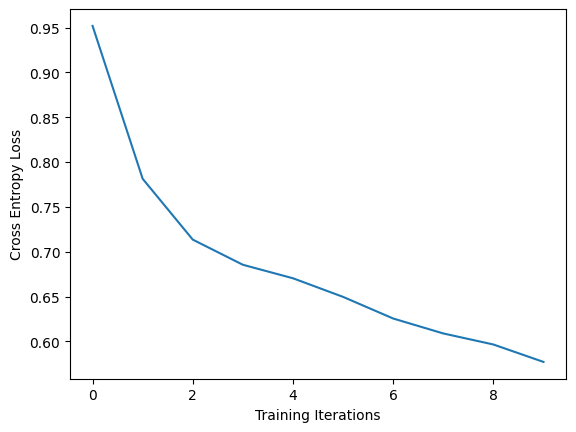

In [16]:
plt.plot(loss_list)
plt.xlabel("Training Iterations") 
plt.ylabel("Cross Entropy Loss")
plt.show()

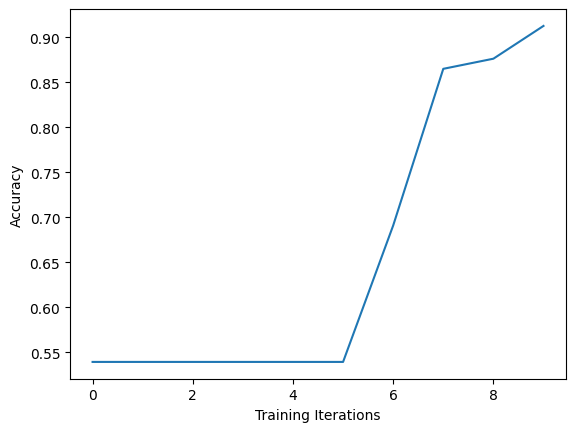

In [17]:
plt.plot(accuracy_list)
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy")
plt.show()

In [8]:
PATH = 'models/birdsong_cnn_quantum.pt'
torch.save(model.state_dict(), PATH)

In [9]:
import torch
PATH = 'models/birdsong_cnn_quantum.pt'
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
from torchmetrics.classification import Accuracy, ConfusionMatrix, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryHingeLoss
model.eval()

CNN(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=356224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [11]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.9353448152542114
Cross-Entropy Loss: 0.4888841211795807
Confusion Matrix:
[[198, 16], [14, 236]]
F1 Score: 0.9402390718460083
Binary Precision: 0.9365079402923584
Binary Recall: 0.9440000057220459


In [12]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in train_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.9378349184989929
Cross-Entropy Loss: 0.5426584482192993
Confusion Matrix:
[[787, 73], [43, 963]]
F1 Score: 0.9431929588317871
Binary Precision: 0.9295367002487183
Binary Recall: 0.9572564363479614


In [13]:
print(loss_list)

[0.9518752997204408, 0.7813223095263465, 0.7134585229016966, 0.6854195897862062, 0.6703466722520731, 0.6495926713539382, 0.6254575939501746, 0.608799626261501, 0.5964752486196615, 0.577032231678397]


In [14]:
print(accuracy_list)

[0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.6907824277877808, 0.8649517893791199, 0.8762058019638062, 0.9126473665237427]


In [19]:
y_pred_probs

tensor([[0.5658, 0.4342],
        [0.3891, 0.6109],
        [0.3801, 0.6199],
        ...,
        [0.3828, 0.6172],
        [0.5690, 0.4310],
        [0.5496, 0.4504]])

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer 
loss_func = CrossEntropyLoss() # Loss Functions
epochs = 5  # Set number of epochs

model.train()  # Set model to training mode

start_time = time.time()

for epoch in range(epochs):
    y_true = []
    y_pred_probs = []
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(loss)
        probabilities = F.softmax(output, dim=1)
        y_true.extend(target.tolist())
        y_pred_probs.extend(probabilities.tolist())
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    y_pred_probs = torch.tensor(y_pred_probs)
    y_pred = torch.argmax(y_pred_probs, dim=1)
    accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
    accuracy_list.append(accuracy.item())
    print("Accuracy:", accuracy.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    
end_time = time.time()  # Record end time
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

tensor(0.5508, grad_fn=<NllLossBackward0>)
tensor(0.5532, grad_fn=<NllLossBackward0>)
tensor(0.5480, grad_fn=<NllLossBackward0>)
tensor(0.5477, grad_fn=<NllLossBackward0>)
tensor(0.5625, grad_fn=<NllLossBackward0>)
tensor(0.5621, grad_fn=<NllLossBackward0>)
tensor(0.5629, grad_fn=<NllLossBackward0>)
tensor(0.5722, grad_fn=<NllLossBackward0>)
tensor(0.5656, grad_fn=<NllLossBackward0>)
tensor(0.5822, grad_fn=<NllLossBackward0>)
tensor(0.5818, grad_fn=<NllLossBackward0>)
tensor(0.5592, grad_fn=<NllLossBackward0>)
tensor(0.5601, grad_fn=<NllLossBackward0>)
tensor(0.5568, grad_fn=<NllLossBackward0>)
tensor(0.5407, grad_fn=<NllLossBackward0>)
tensor(0.5678, grad_fn=<NllLossBackward0>)
tensor(0.5965, grad_fn=<NllLossBackward0>)
tensor(0.5587, grad_fn=<NllLossBackward0>)
tensor(0.5730, grad_fn=<NllLossBackward0>)
tensor(0.5460, grad_fn=<NllLossBackward0>)
tensor(0.5474, grad_fn=<NllLossBackward0>)
tensor(0.5711, grad_fn=<NllLossBackward0>)
tensor(0.5596, grad_fn=<NllLossBackward0>)
tensor(0.55

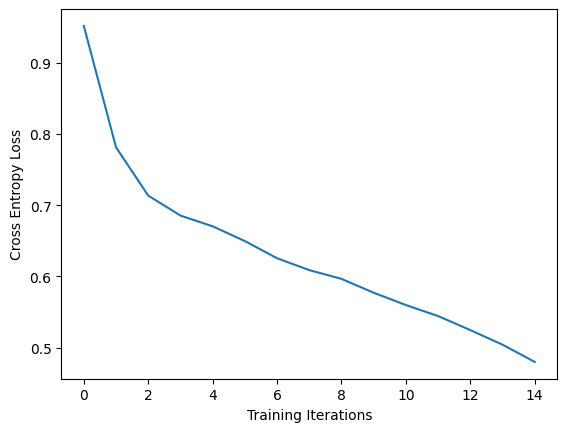

In [21]:
plt.plot(loss_list)
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

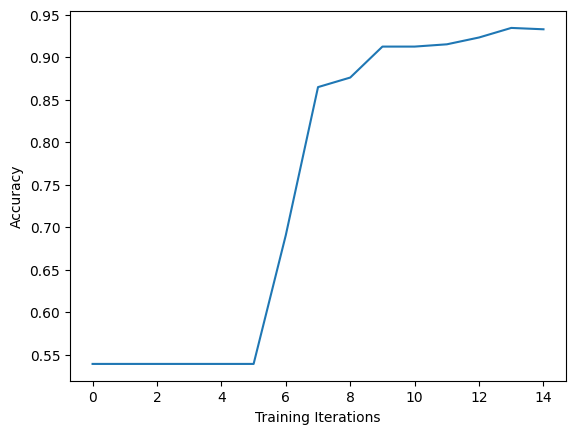

In [22]:
plt.plot(accuracy_list)
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy")
plt.show()

In [23]:
PATH = 'models/birdsong_cnn_quantum-1.pt'
torch.save(model.state_dict(), PATH)

In [24]:
import torch
PATH = 'models/birdsong_cnn_quantum-1.pt'
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
from torchmetrics.classification import Accuracy, ConfusionMatrix, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryHingeLoss
model.eval()

CNN(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=356224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [26]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())


Accuracy: 0.9504310488700867
Cross-Entropy Loss: 0.4276125431060791
Confusion Matrix:
[[204, 10], [13, 237]]
F1 Score: 0.953722357749939
Binary Precision: 0.9595141410827637
Binary Recall: 0.9480000138282776


In [27]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in train_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.9523044228553772
Cross-Entropy Loss: 0.5529411435127258
Confusion Matrix:
[[813, 47], [42, 964]]
F1 Score: 0.955875039100647
Binary Precision: 0.9535113573074341
Binary Recall: 0.9582505226135254


In [28]:
print(loss_list)

[0.9518752997204408, 0.7813223095263465, 0.7134585229016966, 0.6854195897862062, 0.6703466722520731, 0.6495926713539382, 0.6254575939501746, 0.608799626261501, 0.5964752486196615, 0.577032231678397, 0.559698154360561, 0.5442236075967045, 0.5245351508512335, 0.5039926242020171, 0.4797930131524296]


In [29]:
print(accuracy_list)

[0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.5391210913658142, 0.6907824277877808, 0.8649517893791199, 0.8762058019638062, 0.9126473665237427, 0.9126473665237427, 0.9153268933296204, 0.9233654737472534, 0.9346194863319397, 0.9330117702484131]


In [30]:
y_pred_probs

tensor([[0.6537, 0.3463],
        [0.2993, 0.7007],
        [0.6490, 0.3510],
        ...,
        [0.4098, 0.5902],
        [0.6469, 0.3531],
        [0.3513, 0.6487]])